In [1]:
import sys
import os
sys.path.insert(0,os.getcwd()+"/torch-ngp")

import torch
from nerf.network_tcnn import NeRFNetwork
from nerf.provider import NeRFDataset
from nerf.utils import *
from easydict import EasyDict

import numpy as np
from helpers import *

In [2]:
seq_name = "desk_concave"
loss_type = "rgb"
epochs = 10
bound = 3
scale = 0.33
num_ray_patches = 512
workspace = "desk_concave"

In [3]:
model = NeRFNetwork(
    encoding="hashgrid", encoding_dir="sphere_harmonics", 
    num_layers=2, hidden_dim=64, geo_feat_dim=15, num_layers_color=3, hidden_dim_color=64, 
    cuda_ray=True,
)

criterion = torch.nn.HuberLoss(delta=0.1).cuda()

optimizer = lambda model: torch.optim.Adam([
    {'name': 'encoding', 'params': list(model.encoder.parameters())},
    {'name': 'net', 'params': list(model.sigma_net.parameters()) + list(model.color_net.parameters()), 'weight_decay': 1e-6},
], lr=1e-2, betas=(0.9, 0.99), eps=1e-15)

opt = EasyDict()
opt.gui = False
opt.path = "data/"+seq_name
opt.mode = "colmap"
opt.scale = scale
opt.bound = bound
opt.num_rays = num_ray_patches*9

train_dataset = NeRFDataset(opt.path, type='train', mode=opt.mode, scale=opt.scale, preload=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

scheduler = lambda optimizer: optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150], gamma=0.33)
trainer = Trainer('ngp', vars(opt), model, workspace="workspace/"+workspace, optimizer=optimizer, criterion=criterion, ema_decay=0.95, fp16=True, lr_scheduler=scheduler)

bg_color = torch.ones(3, device="cuda") # [3], fixed white background
bar = tqdm.tqdm(range(trainer.epoch,epochs),initial=trainer.epoch,total=epochs,desc="Epochs")


[INFO] Trainer: ngp | 2022-04-07_20-01-08 | cuda:0 | fp16 | workspace/desk_concave

[INFO] #parameters: 28985744

[INFO] Loading latest checkpoint ...

[WARN] No checkpoint found, model randomly initialized.

Epochs:  10%|████                                     | 1/10 [00:00<?, ?it/s]

In [4]:
for epoch in bar:
    torch.cuda.empty_cache()

    with torch.cuda.amp.autocast():
        trainer.model.update_extra_state(bound)
    losses = 0

    for data in tqdm.tqdm(train_loader,desc="Samples",leave=False):
        data = trainer.prepare_data(data)

        trainer.optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            #preds, truths, loss = trainer.train_step(data)
            images = data["image"][...,:3] # [B, H, W, 3/4]
            poses = data["pose"] # [B, 4, 4]
            intrinsics = data["intrinsic"] # [B, 3, 3]

            # sample rays 
            B, H, W, C = images.shape
            rays_o, rays_d, inds = get_patched_rays(poses, intrinsics, H, W, num_ray_patches)#my_rays(poses, intrinsics, H, W, 4608)
            images = torch.gather(images.reshape(B, -1, C), 1, torch.stack(C*[inds], -1)) # [B, N, 3/4]

            gt_rgb = images.reshape((-1,3,3,3))

            outputs = trainer.model.render(rays_o, rays_d, staged=False, bg_color=bg_color, perturb=True, bound=bound)
            pred_rgb = outputs['rgb'].reshape((-1,3,3,3))
            pred_depth = outputs['depth'].reshape((-1,3,3))+1e-6

            rgb_loss = trainer.criterion(pred_rgb, gt_rgb)

            if loss_type == "smooth":
                v00 = pred_depth[:, :-1, :-1]
                v01 = pred_depth[:, :-1, 1:]
                v10 = pred_depth[:, 1:, :-1]
                depth_loss = ((v00 - v01) ** 2 + (v00 - v10) ** 2).mean()
                loss = rgb_loss + 1e-2 * depth_loss
            elif loss_type == "normal":
                dgs_loss = loss_3dgs(inds,pred_depth,pred_rgb, W, fx, fy, cx, cy)
                loss = rgb_loss + 1e-4 * dgs_loss
            else:
                loss = rgb_loss

            preds, truths, loss = pred_rgb, gt_rgb, loss

        trainer.scaler.scale(loss).backward()
        trainer.scaler.step(trainer.optimizer)
        trainer.scaler.update()

        loss_val = loss.item()
        losses += loss_val/len(train_loader)

    bar.set_description("Epochs (mean loss {}):".format(losses))
    #print(pred_rgb,pred_depth)
    trainer.ema.update()
    trainer.lr_scheduler.step()



Samples:   0%|                                        | 0/80 [00:00<?, ?it/s]/opt/anaconda/envs/prj/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

Samples:  98%|██████████████████████████████▏| 78/80 [00:04<00:00, 21.74it/s]
Epochs (mean loss 0.020015005301684142)::  20%|▏| 2/10 [00:04<00:35,  4.47s/i
Samples:  98%|██████████████████████████████▏| 78/80 [00:03<00:00, 20.98it/s]
Epochs (mean loss 0.023258393281139433)::  30%|▎| 3/10 [00:08<00:28,  4.12s/i
Samples: 100%|███████████████████████████████| 80/80 [00:05<00:00, 15.65it/s]
Epochs (mean loss 0.011950369772966945)::  40%|▍| 4/10 [00:13<00:27,  4.61s/i
Samples: 100%|███████████████████████████████| 80/80 [00:05<00:00, 14.16it/s]
Epochs

KeyboardInterrupt: 

In [3]:
from easydict import EasyDict

name = "desk_concave"

opt = EasyDict()
opt.gui = False
opt.path = "../instant-ngp/data/nerf/"+name#"../instant-ngp/data/nerf/fox"#
opt.mode = "colmap"
opt.scale = 0.33
opt.bound = 3
opt.num_rays = 64*64

In [4]:
train_dataset = NeRFDataset(opt.path, type='train', mode=opt.mode, scale=opt.scale, preload=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

In [5]:
valid_dataset = NeRFDataset(opt.path, type='val', mode=opt.mode, scale=opt.scale)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1)

In [6]:
# need different milestones for GUI/CMD mode.
scheduler = lambda optimizer: optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000, 1500, 2000] if opt.gui else [50, 100, 150], gamma=0.33)

trainer = Trainer('ngp', vars(opt), model, workspace=name, use_checkpoint=None, optimizer=optimizer, criterion=criterion, ema_decay=0.95, fp16=True, lr_scheduler=scheduler,eval_interval=10,  )

# need different dataset type for GUI/CMD mode.


[INFO] Trainer: ngp | 2022-04-07_19-46-59 | cuda:0 | fp16 | desk_concave

[INFO] #parameters: 28985744

[INFO] Loading None ...

[WARN] No checkpoint found, model randomly initialized.

In [7]:
#trainer.train(train_loader,valid_loader,60)

352 640


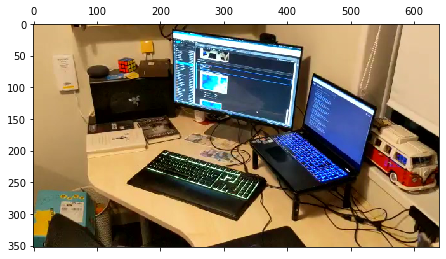

In [7]:
import matplotlib.pyplot as plt

sample = valid_dataset[:1]
pose = sample["pose"] # B, 4, 4]
intr = sample["intrinsic"]
focal = intr[0,0].item()
H,W = sample["image"].shape[-3:-1]
img = sample["image"].cpu()
#depth = cv2.imread("../instant-ngp/data/nerf/pumpkin/seq-01/depth/frame-000420.depth.png",-1)
depth = cv2.imread("../nerf-pytorch/data/nerf_synthetic/lego/test/r_0_depth_0001.png",-1)[...,-1]#.max()
print(H,W)
plt.matshow(img[0])

In [8]:

def get_patched_rays(c2w, intrinsics, H, W, n_patches=512,patch_dim=3):
    # modified from torch-ngp
    device = c2w.device
    rays_o = c2w[..., :3, 3] # [B, 3]
    prefix = c2w.shape[:-2]

    i, j = torch.meshgrid(torch.linspace(0, W-1, W, device=device), torch.linspace(0, H-1, H, device=device), indexing='ij') # for torch < 1.10, should remove indexing='ij'
    i = i.t().reshape([*[1]*len(prefix), H*W]).expand([*prefix, H*W])
    j = j.t().reshape([*[1]*len(prefix), H*W]).expand([*prefix, H*W])

    y,x = torch.randint(0,H-patch_dim,(n_patches,),device=device),torch.randint(0,W-patch_dim,(n_patches,),device=device)
    select_hs, select_ws = torch.meshgrid((torch.linspace(0, patch_dim-1, patch_dim, device=device).long(),torch.linspace(0, patch_dim-1, patch_dim, device=device).long()))
    select_inds = (y+select_hs.ravel()[:,None]).T.ravel() * W + (x+select_ws.ravel()[:,None]).T.ravel()
    select_inds = select_inds.expand([*prefix, n_patches*patch_dim**2])
    i = torch.gather(i, -1, select_inds)
    j = torch.gather(j, -1, select_inds)

    pixel_points_cam = lift(i, j, torch.ones_like(i), intrinsics=intrinsics)
    pixel_points_cam = pixel_points_cam.transpose(-1, -2)

    world_coords = torch.bmm(c2w,pixel_points_cam).transpose(-1, -2)[..., :3]
    
    rays_d = world_coords - rays_o[..., None, :]
    rays_d = F.normalize(rays_d, dim=-1)

    rays_o = rays_o[..., None, :].expand_as(rays_d)

    return rays_o, rays_d, select_inds

In [158]:
@torch.jit.script
def project_to_3d(inds, depth, W:int, fx:float, fy:float, cx:float, cy:float):
    """Projects points from flat image space to 3D camera reference space
       
       Args:
           inds  (1D tensor) of pixel indices 
           depth (1D tensor) of predicted depth values
           W     (int)       Image width
           fx    (float)     focal length in x-direction
           fy    (float)     focal length in y-direction
           cx    (float)     camera principle point in x-direction
           cy    (float)     camera principle point in y-direction
       Returns:
           3D tensor: 3d points 
    """
    patch_inds = inds.reshape((-1,9)) # group by local image patches

    u = patch_inds%W 
    v = patch_inds//W
    d = depth.reshape((-1,9))
    
    x_over_z = (cx - u) / fx
    y_over_z = (cy - v) / fy
    z = d / torch.sqrt(1. + x_over_z**2 + y_over_z**2)
    x = x_over_z * z
    y = y_over_z * z

    return torch.stack((x,y,z),-1)

@torch.jit.script
def get_normal_matrix(points): 
    """Generate normal vector matrix for 3x3 point patches
       
       Args:
           points  (3D tensor)
       Returns:
           (n,3,3,3) tensor: list of 3x3 matrix of normal vectors 
    """
    centers = points[:,4] # get central point
    outers = points[:,[3,0,1,2,5,8,7,6,3]] # get surrounding points in clockwise order

    # calculate normal vectors
    vecs = outers - centers[:,None] 
    norms = torch.cross(vecs[:,:-1],vecs[:,1:])
    norm = norms.mean(1)

    # generate normal vector matrix
    A = torch.empty((len(norm),9,3)).cuda()
    A[:,[0,1,2,5,7,8,6,3]] = norms
    A[:,4] = norm
    
    # normalize matrix
    A = A/torch.norm(A,dim=-1)[...,None]
    
    return A.reshape((-1,3,3,3))

@torch.jit.script
def rowwise_dot(a,b):
    # row-wise dot product
    return (a*b).sum(-1)

@torch.jit.script
def rowwise_norm(a):
    # row-wise norm
    return torch.sqrt((a**2).sum(-1))

@torch.jit.script
def sine_distance(v1,v2):
    # sine distance function
    return 1-(rowwise_dot(v1,v2)/(v1.norm(2,-1)*v2.norm(2,-1)))**2

@torch.jit.script
def xy_grad_patches(a):
    # helper function to return matrix with differnt offsets to calculate gradients 
    return a[:, :-1, :-1],\
           a[:, :-1, 1:],\
           a[:, 1:, :-1]
        
@torch.jit.script
def xy_grad(a):
    # calculate gradient of matrix "a" in x and y direction 
    a00,a01,a10 = xy_grad_patches(a)
    
    return (a00-a01)**2, (a00-a10)**2
        
@torch.jit.script
def get_loss_3dgs(depth_patches, image_patches, A):    
    """Calculaet the 3dgs loss
       
       Args:
           depth_patches  (3x3 depth values)
           image_patches  (3x3x3 radiance values)
           A              (nx3x3x3 normal vectors)
       Returns:
           float: 3dgs loss
    """
    
    dxD,dyD = xy_grad(depth_patches)  # gradient of depth values
    dxI, dyI = xy_grad(image_patches) # gradient of radiance values 
    
    A00,A01,A10 = xy_grad_patches(A) # gradient of normal vectors
    sxA = sine_distance(A00,A01) # sine distance of normal vectors in x-direction
    syA = sine_distance(A00,A10) # sine distance of normal vectors in y-direction

    edxI = torch.norm(torch.exp(-dxI).reshape((-1,12)),dim=1)[:,None,None] # scaling factor in x-direction
    edyI = torch.norm(torch.exp(-dyI).reshape((-1,12)),dim=1)[:,None,None] # scaling factor in y-direction

    dgs_loss = edxI * (sxA + dxD) + edyI * (syA + dyD) # final equation
    
    return torch.nan_to_num(dgs_loss,1.0,1.0).mean()

@torch.jit.script
def loss_3dgs(inds, depth_patches, image_patches, W:int, fx:float, fy:float, cx:float, cy:float):
    # Helper function to combine steps
    points = project_to_3d(inds,depth_patches, W, fx, fy, cx, cy)
    A = get_normal_matrix(points)
    return get_loss_3dgs(depth_patches, image_patches, A)

  0%|                                                 | 0/80 [00:00<?, ?it/s]/opt/anaconda/envs/prj/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|████████████████████████████████████████| 80/80 [00:04<00:00, 18.80it/s]


3 0.020315976254642015
0 loss: 0.020315976254642015


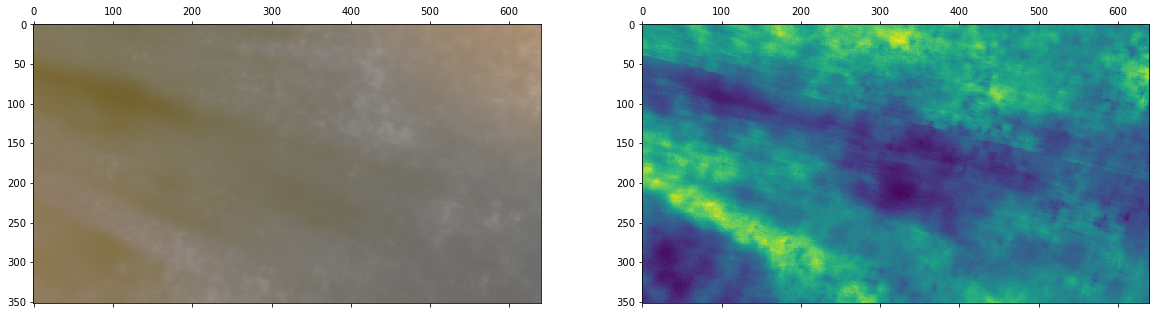

100%|████████████████████████████████████████| 80/80 [00:03<00:00, 21.80it/s]


3 0.020319456479046497
1 loss: 0.020319456479046497


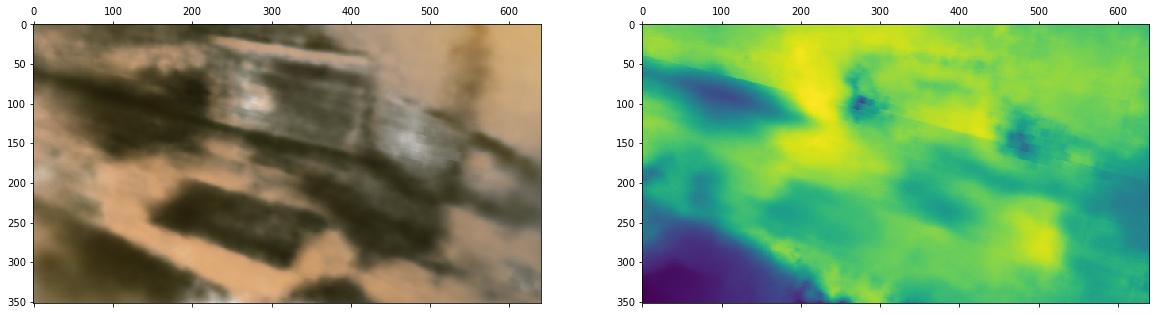

100%|████████████████████████████████████████| 80/80 [00:06<00:00, 11.62it/s]


3 0.008484874578425658
2 loss: 0.008484874578425658


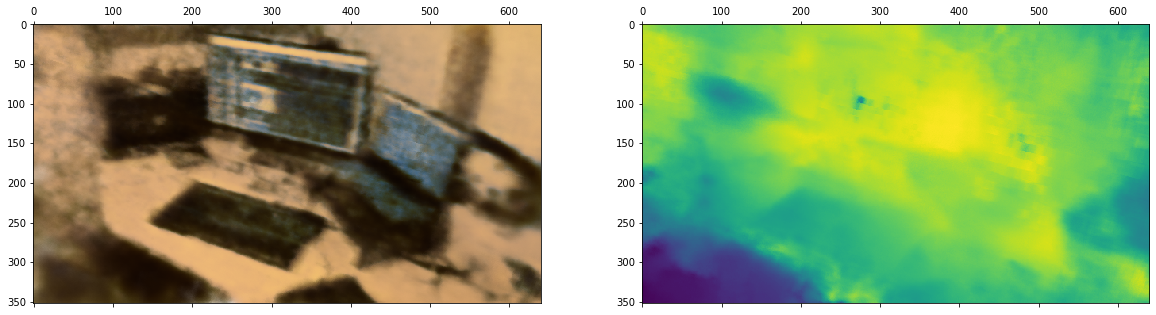

  1%|▌                                        | 1/80 [00:00<00:08,  9.73it/s]


RuntimeError: /home/mebenstein/Dropbox/prototypes/PRJ/tiny-cuda-nn/include/tiny-cuda-nn/gpu_memory.h:523 cuMemCreate(&m_handles.back(), n_bytes_to_allocate, &prop, 0) failed with error CUDA_ERROR_OUT_OF_MEMORY

In [9]:
trainer.model.train()

for epoch in range(50):
    bound = 3#min((epoch+10)**1.2/20.0,3)
    
    torch.cuda.empty_cache()
    with torch.cuda.amp.autocast():
        trainer.model.update_extra_state(bound)
    losses = 0
    
    for data in tqdm.tqdm(train_loader):
        data = trainer.prepare_data(data)

        trainer.optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            #preds, truths, loss = trainer.train_step(data)
            images = data["image"][...,:3] # [B, H, W, 3/4]
            poses = data["pose"] # [B, 4, 4]
            intrinsics = data["intrinsic"] # [B, 3, 3]

            # sample rays 
            B, H, W, C = images.shape
            rays_o, rays_d, inds = get_patched_rays(poses, intrinsics, H, W, 512)#my_rays(poses, intrinsics, H, W, 4608)
            images = torch.gather(images.reshape(B, -1, C), 1, torch.stack(C*[inds], -1)) # [B, N, 3/4]

            # train with random background color if using alpha mixing
            #bg_color = torch.ones(3, device=images.device) # [3], fixed white background
            bg_color = torch.rand(3, device=images.device) # [3], frame-wise random.
            gt_rgb = images.reshape((-1,3,3,3))

            outputs = trainer.model.render(rays_o, rays_d, staged=False, bg_color=bg_color, perturb=True, bound=bound)
            pred_rgb = outputs['rgb'].reshape((-1,3,3,3))
            pred_depth = outputs['depth'].reshape((-1,3,3))+1e-6

            rgb_loss = trainer.criterion(pred_rgb, gt_rgb)
            #v00 = pred_depth[:, :-1, :-1]
            #v01 = pred_depth[:, :-1, 1:]
            #v10 = pred_depth[:, 1:, :-1]
            #depth_loss = ((v00 - v01) ** 2 + (v00 - v10) ** 2).mean()
            #dgs_loss = loss_3dgs(inds,pred_depth,pred_rgb, W, fx, fy, cx, cy)
            
            loss = rgb_loss# + 1e-2 * depth_loss#+ 1e-4 * dgs_loss #+ 1e-2 * depth_loss#
            #lll
            preds, truths, loss = pred_rgb, gt_rgb, loss
            
        trainer.scaler.scale(loss).backward()
        trainer.scaler.step(trainer.optimizer)
        trainer.scaler.update()

        loss_val = loss.item()
        losses += loss_val/len(train_loader)
    
    trainer.ema.update()
    trainer.lr_scheduler.step()
    
    print(bound, losses) 
        
    if epoch%1 == 0:# and epoch > 0:
        print(epoch,"loss:",losses)
        
        fig, plots = plt.subplots(1,2,figsize=(20,10))
        res = trainer.test_gui(pose[0],intr,W,H)
        plots[0].matshow(res["image"])
        plots[1].matshow(res["depth"])
        plt.show()

        trainer.model.train()

In [14]:
! cd ../torch-ngp && git log

commit 56478bdcf5de5f69e0918ccd3a40ac4b2fd32481 (HEAD)
Author: Michael Ebenstein <michael@ebenstein.eu>
Date:   Thu Apr 7 00:18:39 2022 +0100

    update

commit 0bd19140ba9aaa5fea26f24a2c258687553e5e0a
Author: ashawkey <ashawkey1999@gmail.com>
Date:   Tue Mar 1 16:49:17 2022 +0800

    refactor train scripts

commit 4c440de1575e8c0cae5f6e6ae75c850de8101b10
Author: ashawkey <ashawkey1999@gmail.com>
Date:   Tue Mar 1 16:48:45 2022 +0800

    refactor train scripts

commit 1c3bf61bebf9a95b5c2c18396626d7b5b2651a48
Author: ashawkey <ashawkey1999@gmail.com>
Date:   Tue Mar 1 15:55:42 2022 +0800

    update readme

commit e0ad2ecb3f4884c61015d5772f8ca930ae4c6a7a
Author: ashawkey <ashawkey1999@gmail.com>
Date:   Tue Mar 1 15:54:44 2022 +0800

    support dataset type="all"

commit b4f6cb8d2930542e32e2080c770c89013e372c47
Author: ashawkey <ashawkey1999@gmail.com>
Date:   Mon Feb 28 17:19:01 2022 +0800

    change to huberloss

commit 49af081f8e19bdf27f91e9829880d0dc0cc727e2
Author: ashawkey <a

In [16]:
pred_rgb

tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        ...,


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 

In [21]:
data["image"][...,:3].shape

torch.Size([1, 800, 800, 3])

In [17]:
 data["image"].shape

torch.Size([1, 800, 800, 4])

352 640


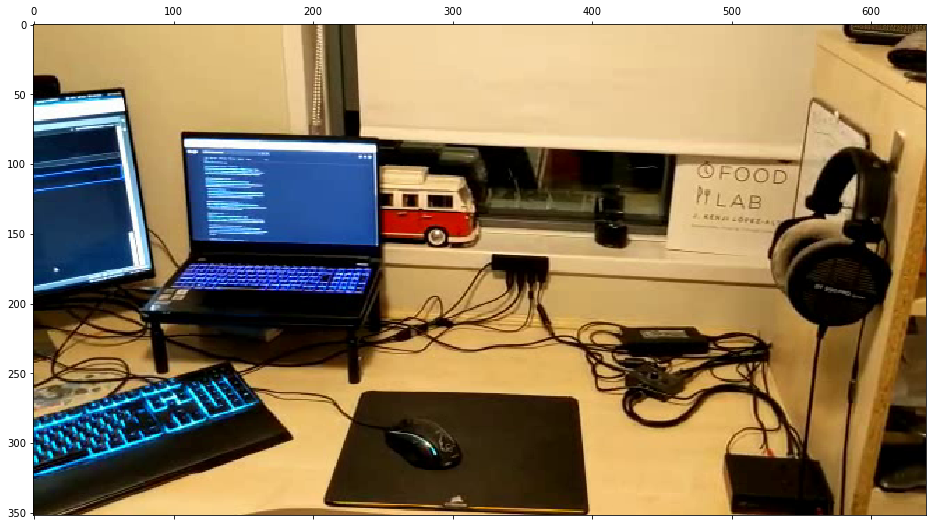

In [184]:
import matplotlib.pyplot as plt

sample = train_dataset[:1]
pose = sample["pose"] # [B, 4, 4]
intr = sample["intrinsic"]
H,W = sample["image"].shape[-3:-1]
print(H,W)
plt.matshow(sample["image"][0].cpu())

In [185]:
pred = trainer.test_gui(pose[0],intr,W,H)

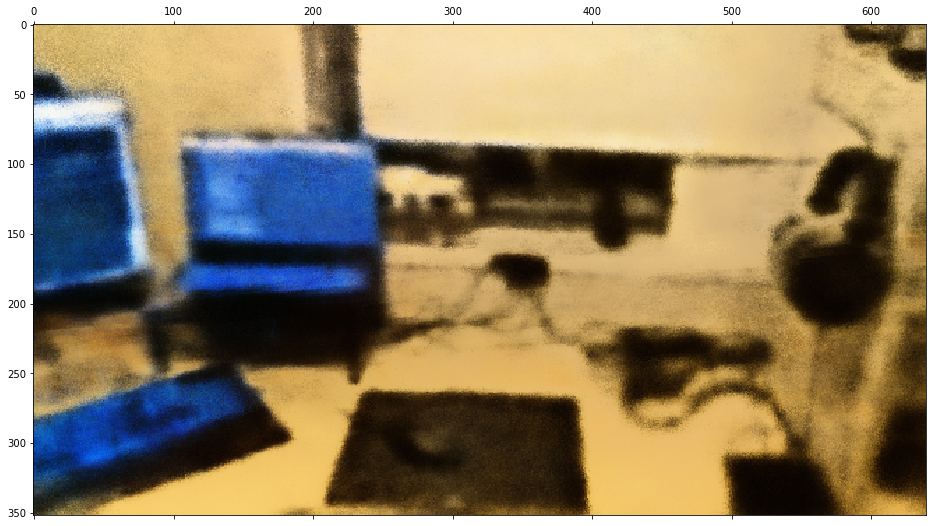

In [191]:
plt.rcParams["figure.figsize"] = (20,10)
plt.matshow(pred["image"])

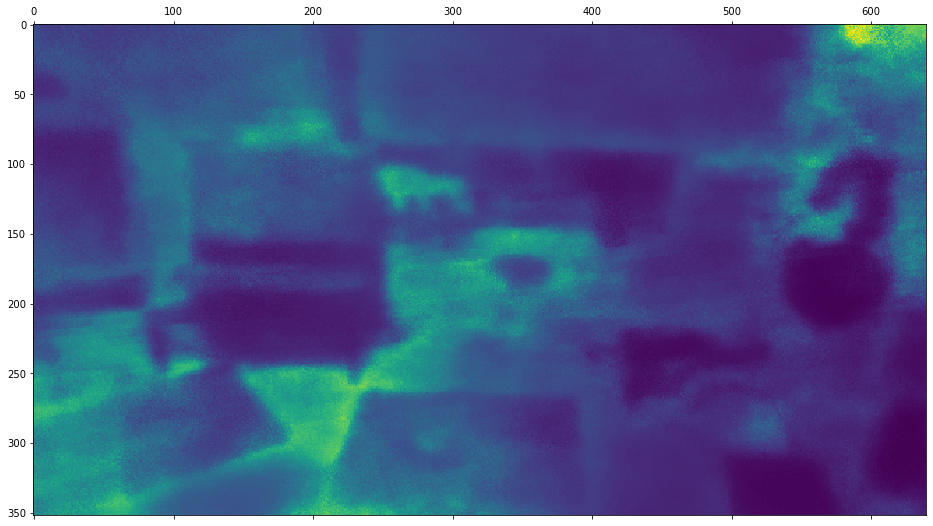

In [192]:
plt.matshow(pred["depth"])

In [193]:
o,v,inds = get_rays(pose,train_dataset.intrinsic,H,W)
points = (o[0].cpu() + torch.nn.functional.normalize(v[0].cpu()) * pred["depth"].reshape((-1,1))).reshape((-1,3))

In [194]:
from meshplot import plot

plot(points.numpy()*0.35,c=pred["image"].reshape((-1,3)))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.436438…

In [195]:
print("PSRN",PSNR(sample["image"].cpu().numpy(),pred["image"]))
print("SSIM",ssim(sample["image"].cpu().numpy()[0],pred["image"],multichannel=True))

PSRN 18.828507931733064
SSIM 0.6641700630893109


In [149]:
print("PSRN",PSNR(sample["image"].cpu().numpy(),pred["image"]))
print("SSIM",ssim(sample["image"].cpu().numpy()[0],pred["image"],multichannel=True))

PSRN 24.571939395789116
SSIM 0.8909309612284604


In [33]:
print("PSRN",PSNR(sample["image"].cpu().numpy(),pred["image"]))
print("SSIM",ssim(sample["image"].cpu().numpy()[0],pred["image"],multichannel=True))

PSRN 23.473221893964293
SSIM 0.853931726289006


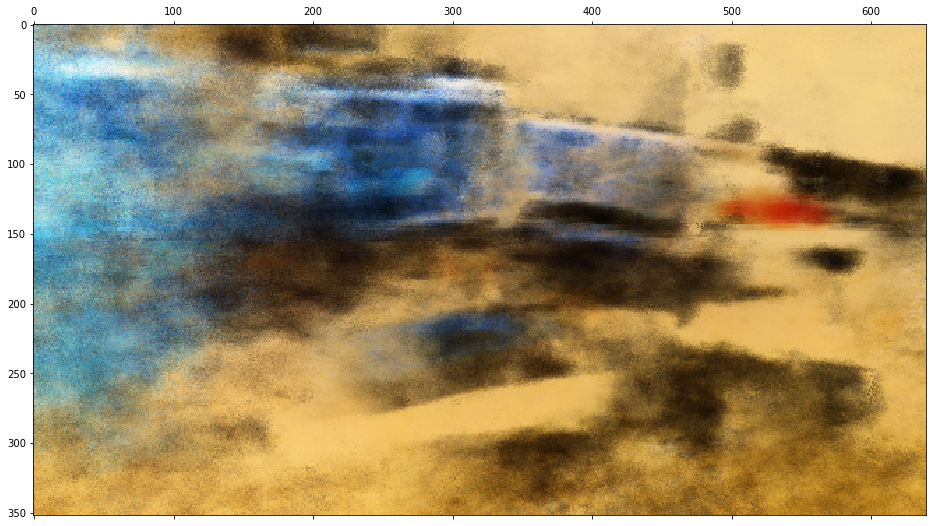

In [196]:
from nerf.provider import nerf_matrix_to_ngp

q = pose_spherical(120,-3,0.2)
#q[:3,-1] += torch.tensor([0,0,2])
test_pose = nerf_matrix_to_ngp(q)#[None,]
pred = trainer.test_gui(test_pose,intr,W,H)

plt.matshow(pred["image"])

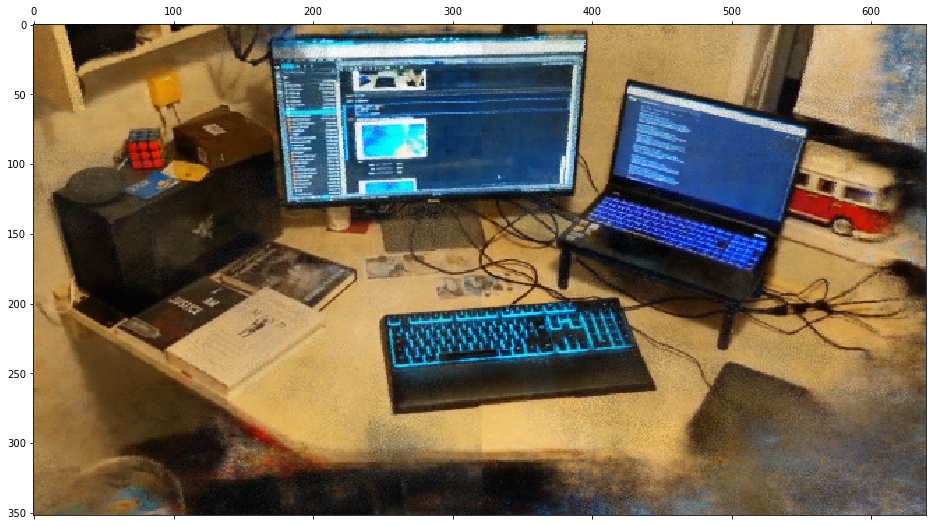

In [139]:
from nerf.provider import nerf_matrix_to_ngp

q = pose_spherical(90,-10,2.5)
#q[:3,-1] += torch.tensor([0,0,2])
test_pose = nerf_matrix_to_ngp(q)#[None,]
pred = trainer.test_gui(test_pose,intr,W,H)

plt.matshow(pred["image"])

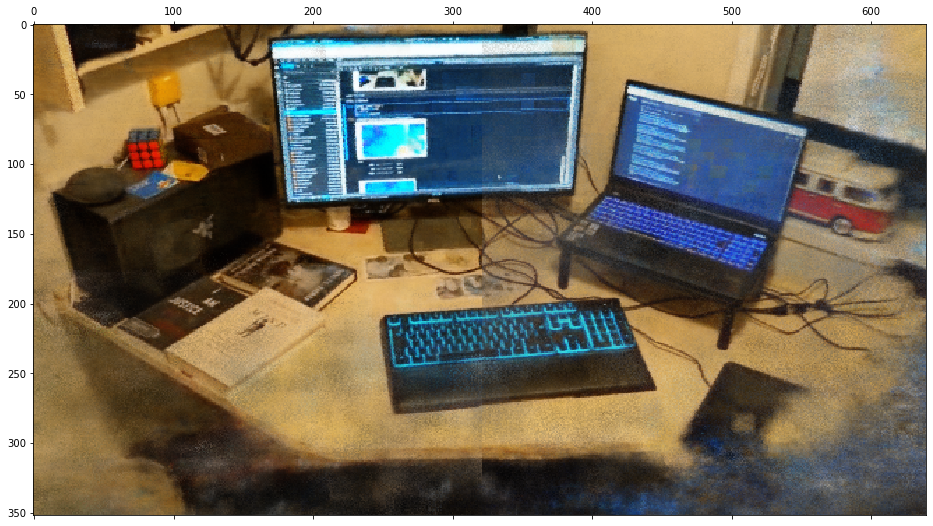

In [161]:
from nerf.provider import nerf_matrix_to_ngp

q = pose_spherical(90,-10,2.5)
#q[:3,-1] += torch.tensor([0,0,2])
test_pose = nerf_matrix_to_ngp(q)#[None,]
pred = trainer.test_gui(test_pose,intr,W,H)

plt.matshow(pred["image"])

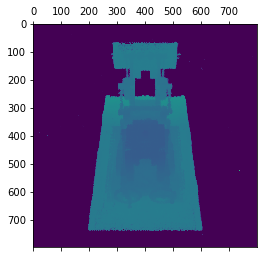

In [93]:
depths = pred["depth"]
d = depths.ravel()
m = d > 0
plt.matshow(depths)

In [162]:
pred["depth"].min()

0.29839298

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets
import numpy as np
from nerf.provider import nerf_matrix_to_ngp

trans_t = lambda t : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=torch.half)

rot_phi = lambda phi : torch.tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=torch.half)

rot_theta = lambda th : torch.tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=torch.half)

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]],dtype=torch.half) @ c2w
    return c2w

def f(**kwargs):
    with torch.no_grad():
        c2w = nerf_matrix_to_ngp(pose_spherical(**kwargs))
        rgb = trainer.test_gui(c2w,intr,800,800)["depth"]

    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 1., 10.]],
]

#interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
#output = interactive_plot.children[-1]
#output.layout.height = '350px'
#interactive_plot

In [69]:
from nerf.utils import get_rays

In [31]:
train_dataset.intrinsic

tensor([[762.3712,   0.0000, 340.3759],
        [  0.0000, 637.7446, 183.7000],
        [  0.0000,   0.0000,   1.0000]], device='cuda:0')

In [177]:
o,v,inds = get_rays(pose[0][None,],train_dataset.intrinsic,H,W)
points = (o[0,m].cpu() + v[0,m].cpu()).reshape((-1,3))

In [12]:
import numpy_indexed as npi

def render_points(points,pose,color):
    a = points-pose[:3,-1]
    b = a @ pose[:3,:3]
    c = b/-b[...,-1:]
    d = c.T*focal + 400
    x,y,_ = d.round().astype(int)
        
    # remove out of bounds
    m = (x >= 0) & (x < 800) & (y >= 0) & (y < 800) & (color.mean(-1) < 0.95)
    
    # z-buffering 
    y,x = y[m],x[m]
    
    inds = np.ravel_multi_index((y,x),(800,800))
    
    sort_map = np.argsort(inds)
    color = color[m]
    
    u,inv = np.unique(inds,return_inverse=True)
    
    #c = npi.group_by(inv).mean(color)[-1]
    c = color[npi.group_by(inv).argmax(b[...,-1][m])[-1]]
    y,x = np.unravel_index(u,(800,800))
    
    img = np.ones((800,800,3))
    img[-y,x,:] = c
    
    return img

@torch.jit.script
def project_to_3d(inds, depth, W:int, fx:float, fy:float, cx:float, cy:float):
    patch_inds = inds#.reshape((-1,9))

    u = patch_inds%W
    v = patch_inds//W
    d = depth#.reshape((-1,9))
    
    x_over_z = (cx - u) / fx
    y_over_z = (cy - v) / fy
    z = d / torch.sqrt(1. + x_over_z**2 + y_over_z**2)
    x = x_over_z * z
    y = y_over_z * z

    return torch.stack((x,y,z),-1)

fx = valid_dataset.intrinsic[0,0].item()
fy = valid_dataset.intrinsic[1,1].item()
cx = valid_dataset.intrinsic[0,-1].item()
cy = valid_dataset.intrinsic[1,-1].item()

In [94]:
o,v,inds = get_rays(pose[None,],train_dataset.intrinsic,H,W)
points = (o[0,m].cpu() + v[0,m].cpu()).reshape((-1,3))

In [179]:
points = project_to_3d(inds,torch.from_numpy(depths).ravel().cuda(),W,fx,fy,cx,cy).cpu()[0]#.numpy()

In [95]:
from meshplot import plot

plot(points.numpy(),c=pred["image"].reshape((-1,3)),shading={"point_size":0.01})

Invalid color array given! Supported are numpy arrays. <class 'numpy.ndarray'>


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.2237627…

In [35]:
from meshplot import plot

plot(points.numpy(),c=pred["image"].reshape((-1,3)),shading={"point_size":0.025})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0379554…

In [47]:
get_rays(pose[0][None,],train_dataset.intrinsic,H,W)

(tensor([[[ 1.1729,  0.4253, -0.4616],
          [ 1.1729,  0.4253, -0.4616],
          [ 1.1729,  0.4253, -0.4616],
          ...,
          [ 1.1729,  0.4253, -0.4616],
          [ 1.1729,  0.4253, -0.4616],
          [ 1.1729,  0.4253, -0.4616]]], device='cuda:0'),
 tensor([[[-0.7638,  0.0191,  0.6452],
          [-0.7643,  0.0191,  0.6446],
          [-0.7648,  0.0191,  0.6439],
          ...,
          [-0.8079, -0.5888, -0.0249],
          [-0.8080, -0.5887, -0.0255],
          [-0.8081, -0.5885, -0.0263]]], device='cuda:0'),
 tensor([[     0,      1,      2,  ..., 639997, 639998, 639999]],
        device='cuda:0'))

In [106]:
import numpy as np

t = 2.3

o = np.random.rand(3)
o /= np.linalg.norm(o)/np.random.rand(1)

d = np.random.rand(3)
d /= np.linalg.norm(d)
p = o + d * t

In [ ]:
(o+t*d) = sqrt(1)


In [108]:
ray_d = d
ray_o = o
#d = t

In [109]:
d1 = -np.sum(ray_d * ray_o) / np.sum(ray_d * ray_d)
p_mid = ray_o + d1[...,None] * ray_d
p_mid_norm = np.linalg.norm(p_mid)
ray_d_cos = 1. / np.linalg.norm(ray_d)
d2 = np.sqrt(1. - p_mid_norm * p_mid_norm) * ray_d_cos
p_sphere = ray_o + (d1 + d2)[...,None] * ray_d

In [107]:
np.linalg.norm(d)

1.0

In [111]:
(d1 + d2)[...,None]

array([0.95106731])

In [110]:
np.linalg.norm(p_sphere)

0.9999999999999999

In [113]:
np.sum(d**2)

1.0

In [112]:
np.linalg.norm(o+(0.95)*d)

0.9989333189098101

In [77]:
o+(0.21)*d

array([0.57762695, 0.66101871, 0.53156921])

In [37]:
o+0.34*d

array([0.45344202, 0.75692782, 0.48482202])

In [46]:
k = ((np.sqrt(3)-o)/d)
np.linalg.norm(o+k*d)

5.196152422706632

In [62]:
(1-np.linalg.norm(o))/np.linalg.norm(d)

0.7926262118501981

In [25]:
np.linalg.norm(o)

0.5924621243605821

In [28]:
np.linalg.norm(d)

1.05981618985371

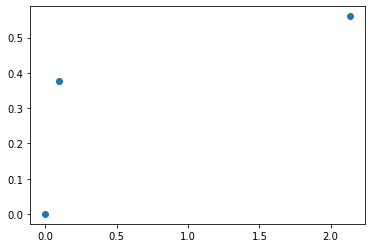

In [17]:
import matplotlib.pyplot as plt

plt.scatter([0,o[0],p[0]],[0,o[1],p[1]])